# Precision Agriculture using Machine Learning

### Importing modules

In [1]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import plotly.graph_objects as go
import plotly.io as pio
import pickle
from sklearn.utils import resample

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, auc, roc_curve

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import RFE

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, LabelEncoder

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [2]:
warnings.filterwarnings('ignore')

sns.set_style("whitegrid", {'axes.grid' : False})
pio.templates.default = "plotly_dark"

### Analyze data

In [3]:
def explore_data(df):
    print("Number of Instances and Attributes:", df.shape)
    print('\n')
    print('Dataset columns:',df.columns)
    print('\n')
    print('Data types of each columns: ', df.info())

### Checking and Removing Duplicate Values from data frame

In [4]:
def checking_removing_duplicates(df):
    count_dups = df.duplicated().sum()
    print("Number of Duplicates: ", count_dups)
    if count_dups >= 1:
        df.drop_duplicates(inplace=True)
        print('Duplicate values removed!')
    else:
        print('No Duplicate values')

### Split training and testing data

In [5]:
def read_in_and_split_data(data, target):
    X = data.drop(target, axis=1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test

### Checking Algorithms

In [6]:
def GetModel():
    Models = []
    Models.append(('LR'   , LogisticRegression()))
    Models.append(('LDA'  , LinearDiscriminantAnalysis()))
    Models.append(('KNN'  , KNeighborsClassifier()))
    Models.append(('CART' , DecisionTreeClassifier()))
    Models.append(('NB'   , GaussianNB()))
    Models.append(('SVM'  , SVC(probability=True)))
    return Models

def ensemblemodels():
    ensembles = []
    ensembles.append(('AB'   , AdaBoostClassifier()))
    ensembles.append(('GBM'  , GradientBoostingClassifier()))
    ensembles.append(('RF'   , RandomForestClassifier()))
    ensembles.append(( 'Bagging' , BaggingClassifier()))
    ensembles.append(('ET', ExtraTreesClassifier()))
    return ensembles

### Checking Normalized Models

In [7]:
def NormalizedModel(nameOfScaler):
    
    if nameOfScaler == 'standard':
        scaler = StandardScaler()
    elif nameOfScaler =='minmax':
        scaler = MinMaxScaler()
    elif nameOfScaler == 'normalizer':
        scaler = Normalizer()
    elif nameOfScaler == 'binarizer':
        scaler = Binarizer()

    pipelines = []
    pipelines.append((nameOfScaler+'LR'  , Pipeline([('Scaler', scaler),('LR'  , LogisticRegression())])))
    pipelines.append((nameOfScaler+'LDA' , Pipeline([('Scaler', scaler),('LDA' , LinearDiscriminantAnalysis())])))
    pipelines.append((nameOfScaler+'KNN' , Pipeline([('Scaler', scaler),('KNN' , KNeighborsClassifier())])))
    pipelines.append((nameOfScaler+'CART', Pipeline([('Scaler', scaler),('CART', DecisionTreeClassifier())])))
    pipelines.append((nameOfScaler+'NB'  , Pipeline([('Scaler', scaler),('NB'  , GaussianNB())])))
    pipelines.append((nameOfScaler+'SVM' , Pipeline([('Scaler', scaler),('SVM' , SVC())])))
    pipelines.append((nameOfScaler+'AB'  , Pipeline([('Scaler', scaler),('AB'  , AdaBoostClassifier())])  ))
    pipelines.append((nameOfScaler+'GBM' , Pipeline([('Scaler', scaler),('GMB' , GradientBoostingClassifier())])  ))
    pipelines.append((nameOfScaler+'RF'  , Pipeline([('Scaler', scaler),('RF'  , RandomForestClassifier())])  ))
    pipelines.append((nameOfScaler+'ET'  , Pipeline([('Scaler', scaler),('ET'  , ExtraTreesClassifier())])  ))

    return pipelines

### Training Model

In [8]:
def fit_model(X_train, y_train,models):
    num_folds = 10
    scoring = 'accuracy'

    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=num_folds, shuffle=True, random_state=0)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

### Saving trained model

In [9]:
def save_model(model,filename):
    pickle.dump(model, open(filename, 'wb'))

### Measuring performance of models

In [10]:
def classification_metrics(model, conf_matrix):
    print(f"Training Accuracy Score: {model.score(X_train, y_train) * 100:.1f}%")
    print(f"Validation Accuracy Score: {model.score(X_test, y_test) * 100:.1f}%")
    fig,ax = plt.subplots(figsize=(8,6))
    sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap = 'YlGnBu',fmt = 'g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title('Confusion Matrix', fontsize=20, y=1.1)
    plt.ylabel('Actual label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.show()
    print(classification_report(y_test, y_pred))

### Data frame

In [11]:
df = pd.read_csv('datasets/Crop_recommendation.csv')
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


### Data Analysis

In [12]:
explore_data(df)

Number of Instances and Attributes: (2200, 8)


Dataset columns: Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label'], dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
Data types of each columns:  None


### Removing Duplicates

In [13]:
checking_removing_duplicates(df)

Number of Duplicates:  0
No Duplicate values


In [14]:
df.isna().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

### Checking and removing Outliers

In [15]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

### Train model

In [16]:
target ='label'
X_train, X_test, y_train, y_test = read_in_and_split_data(df, target)

models = GetModel()
names,results = fit_model(X_train, y_train,models)

LR: 0.954545 (0.016855)
LDA: 0.965909 (0.013203)
KNN: 0.979545 (0.005207)
CART: 0.984659 (0.012199)
NB: 0.993750 (0.004720)
SVM: 0.976705 (0.008214)


### Different Processing techniques

### Minmax

In [17]:
ScaledModel = NormalizedModel('minmax')
name,results = fit_model(X_train, y_train, ScaledModel)

minmaxLR: 0.932955 (0.025763)
minmaxLDA: 0.965909 (0.013203)
minmaxKNN: 0.978409 (0.008351)
minmaxCART: 0.985227 (0.010227)
minmaxNB: 0.993750 (0.004720)
minmaxSVM: 0.982955 (0.006723)
minmaxAB: 0.135795 (0.036862)
minmaxGBM: 0.988636 (0.005682)
minmaxRF: 0.994318 (0.004401)
minmaxET: 0.993182 (0.006120)


### Standard

In [18]:
ScaledModel = NormalizedModel('standard')
name,results = fit_model(X_train, y_train, ScaledModel)

standardLR: 0.969886 (0.014827)
standardLDA: 0.965909 (0.013203)
standardKNN: 0.968750 (0.011149)
standardCART: 0.982955 (0.011644)
standardNB: 0.993750 (0.004720)
standardSVM: 0.982386 (0.008966)
standardAB: 0.141477 (0.036510)
standardGBM: 0.988636 (0.005682)
standardRF: 0.993750 (0.003977)
standardET: 0.992045 (0.005207)


### Normalizer

In [19]:
ScaledModel = NormalizedModel('normalizer')
name,results = fit_model(X_train, y_train, ScaledModel)

normalizerLR: 0.853409 (0.024871)
normalizerLDA: 0.934659 (0.012768)
normalizerKNN: 0.944318 (0.015622)
normalizerCART: 0.932955 (0.014329)
normalizerNB: 0.956250 (0.011090)
normalizerSVM: 0.951705 (0.012768)
normalizerAB: 0.152841 (0.033465)
normalizerGBM: 0.950000 (0.013636)
normalizerRF: 0.973295 (0.007644)
normalizerET: 0.978409 (0.008351)


### Performance Evaluation

Training Accuracy Score: 99.5%
Validation Accuracy Score: 99.3%


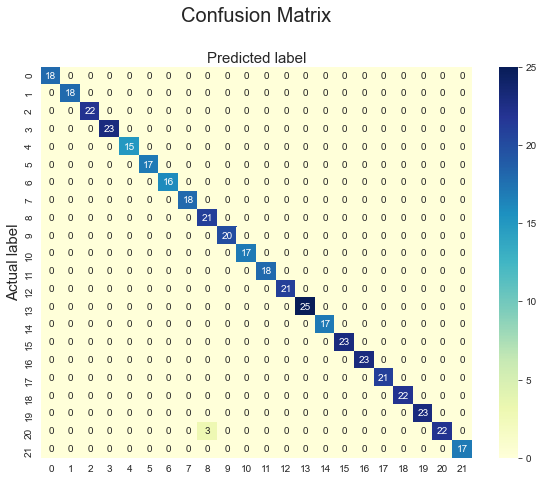

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        18
      banana       1.00      1.00      1.00        18
   blackgram       1.00      1.00      1.00        22
    chickpea       1.00      1.00      1.00        23
     coconut       1.00      1.00      1.00        15
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        16
      grapes       1.00      1.00      1.00        18
        jute       0.88      1.00      0.93        21
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        17
       maize       1.00      1.00      1.00        18
       mango       1.00      1.00      1.00        21
   mothbeans       1.00      1.00      1.00        25
    mungbean       1.00      1.00      1.00        17
   muskmelon       1.00      1.00      1.00        23
      orange       1.00      1.00      1.00        23
      papaya       1.00    

In [20]:
pipeline = make_pipeline(MinMaxScaler(),  GaussianNB())
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test,y_pred)
classification_metrics(pipeline, conf_matrix)

### Saving Model

In [21]:
save_model(model, 'model.pkl')

### Predicting Unseen Data

In [30]:
N = 10
P = 12
K = 10
temperature = 40
humidity = 82
ph = 5
rainfall = 200

sample = [N, P, K, temperature, humidity, ph, rainfall]
single_sample = np.array(sample).reshape(1,-1)
pred = model.predict(single_sample)
pred.item().title()

'Pigeonpeas'